# Creating Customer Segments
___

In this project we will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

The dataset can be downloaded from : https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

It contains the folliwing attributes:
1.	FRESH: annual spending (m.u.) on fresh products (Continuous)
2.	MILK: annual spending (m.u.) on milk products (Continuous)
3.	GROCERY: annual spending (m.u.)on grocery products (Continuous)
4.	FROZEN: annual spending (m.u.)on frozen products (Continuous) 
5.	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
6.	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)
7.	CHANNEL: customer™ Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 
8.	REGION: customers™ Region -  Lisnon, Oporto or Other (Nominal)

We would not be using the 2 columns 'Channel' and 'Region' as they represent classes. Instead we would use the other 6 attributes for customer clustering.

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Tell iPython to include plots inline in the notebook
%matplotlib inline

# read .csv from provided dataset
csv_filename="Wholesale customers data.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

In [2]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
features = df.columns[2:]
features

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

In [4]:
data = df[features]
print(data.head(5))

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185


## Feature Transformation

The first PCA dimension is the dimension in the data with highest variance. Intuitively, it corresponds to the 'longest' vector one can find in the 6-dimensional feature space that captures the data, that is, the eigenvector with the largest eigenvalue.

The first component will carry a high load of the 'Fresh' feature, as this feature seems to vary more than any of the other features (according to the README.md-file, 'Fresh' has the highest variance). Moreover, this feature seems to vary independently of the others, that is, a high or low value of 'Fresh' is not very informative for the values of the other features. A pratical interpretation of these observations could be that some of the supplied customers focus on fresh items, whereas other focus on non-fresh items.

ICA, as opposed to PCA, finds the subcomponents that are statistically independent. ICA also finds 'Fresh' as one of the first components. The other components, however, may differ, as they need not be orthogonal in the feature space (in contrast to PCA). 

### PCA

In [5]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6) # 6 components for 6 variables
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print(pca.components_)
print(pca.explained_variance_ratio_)

[[ 0.97653685  0.12118407  0.06154039  0.15236462 -0.00705417  0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [ 0.04187648  0.64564047 -0.37546049 -0.64629232 -0.14938013  0.02039579]
 [-0.015986   -0.20323566  0.1602915  -0.22018612 -0.20793016  0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


The explained variance is high for the first two dimensions (45.96 % and 40.52 %, respectively), but drops significantly beginning with the third dimension (7.00 % for the third, 4.40 % for the fourth dimension). Thus, the first two components explain already 86.5 % of the variation in the data.

How many dimension to choose for the analysis really depends on the goal of the analysis. Even though PCA reduces the feature space (with all advantages that brings, such as faster computations) and makes interpreting the data easier for us by projecting them down to a lower dimension, it necessarily comes with a loss of information that may or may not be desired.

It the case at hand, assuming interpretation is the goal (creating customer segments) and given the sharp drop of the explained variance after the second component, we would choose the first two dimensions for analysis.

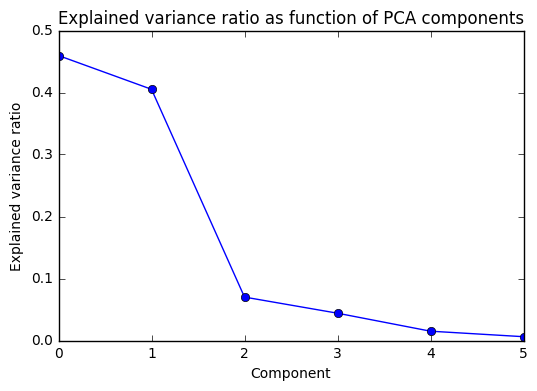

In [6]:
plt.plot(list(pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component')
plt.show()

The first dimension seems to basically represent only the 'fresh'-feature, as this feature has a strong negative projection on the first dimension. The other features have rather weak (mostly negative) projections on the first dimension. That is, the first dimension basically tells us whether the 'fresh'-feature value is high or low, mixed with a little bit of information from the other features.

The second dimension is mainly represented by the features 'Grocery', 'Milk' and 'Detergents', in the order of decreasing importance, and has rather low correlation with the other features.

There are two main uses of this information. The first use is feature interpretation and hypothesis formation. We could form initial conjectures about the customer segments contained in the data. One conjecture could be that the bulk of customers can be split into customers ordering mainly 'fresh' items and customers mainly ordering 'Grocery', 'Milk' and 'Detergents' from the wholesale distributor. The second use is that, given knowledge of the PCA components, new features can be engineered for further analysis of the problem. These features could be generated by applying an exact PCA-transformation or by using some heuristic based on the feature combinations recovered in PCA.

### ICA

In [7]:
# Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
def center_data(data, rescale = 0):
    centeredData = data.copy()
    for col in centeredData.columns:
        centeredData[col] = (centeredData[col] - np.mean(centeredData[col]))/ (1 + rescale * np.std(centeredData[col]))
    return centeredData

from sklearn.decomposition import FastICA
#data_centered = center_data(data)

ica = FastICA(n_components=6, whiten=True)
ica.fit(center_data(data,0))

# Print the independent components
print(ica.components_)

# Print the independent components (rescaled again)
print('Independent components scaled with mean')
print(np.multiply(ica.components_,list(np.mean(data))))

[[ -2.74750657e-07   2.48856352e-06   1.16059751e-05  -1.48757046e-06
   -2.80619738e-05  -5.69826563e-06]
 [  3.97798492e-06  -8.91221623e-07  -7.37147347e-07  -6.67184699e-07
    2.31765570e-06  -9.68872424e-07]
 [  3.88102558e-07   2.41511953e-07   5.81460867e-07   5.27946533e-07
   -5.00502570e-07  -1.81079160e-05]
 [  8.64027159e-07   1.38829776e-07  -7.70771017e-07  -1.11465618e-05
    5.39460191e-07   5.94210415e-06]
 [  2.00851727e-07  -1.79251002e-06   7.14897994e-06   3.15277260e-07
   -2.47481579e-06  -1.77717934e-06]
 [  1.61978460e-07   9.81519765e-06  -5.87798423e-06  -3.57537381e-07
    3.54446077e-06  -5.97842711e-06]]
Independent components scaled with mean
[[-0.00329709  0.01442438  0.09228233 -0.00456972 -0.08086039 -0.00868912]
 [ 0.047737   -0.00516576 -0.00586126 -0.00204955  0.00667831 -0.0014774 ]
 [ 0.00465735  0.00139987  0.00462336  0.00162182 -0.00144219 -0.02761223]
 [ 0.01036858  0.00080469 -0.00612861 -0.03424148  0.00155445  0.00906094]
 [ 0.00241028 -0.

The first vector [-0.04771087  0.00496636  0.00492989  0.00208307 -0.0059068   0.00159593] again represents mainly the 'fresh'-feature, with a coefficient of -0.0477. The other features have a rather weak projection on the first dimension.

The second vector [ 0.00182027  0.0571306  -0.04596392 -0.00113553  0.00928388 -0.00925863] corresponds mainly to the features 'Milk' and 'Grocery', but in different directions. This indicates that, other things equal, high 'Milk'-spending is associated with low 'Grocery'-spending and vice versa.

The third vector [ 0.00360762 -0.01311074 -0.09638513  0.00448148  0.08132511  0.00872532] has as strong association with the 'Grocery'- and 'Detergents_Paper'-features, again in opposite directions. This indicates a negative association between these features across the wholesalers customers. 

The main charactistic of the fourth vector [ 0.00463807  0.00127625  0.00476776  0.00160491 -0.00146026 -0.02758939] is that this vector has a relatively strong negative association with 'delicatessen' (and only rather weak associations with the other features). Even though the coefficient are very low, the vector permits the interpretation that 'delicatessen' are negativly related to the 'fresh'- and 'grocery'-features.


## Clustering

In this section we will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then we will sample elements from the clusters to understand their significance.

### Choosing a Cluster Type

#### K Means Clustering or Gaussian Mixture Models?

Before discussing the advantages of K Means vs Gaussian Mixture models, it is helpful to observe that both methods are actually very similar. The main difference is that Gaussian Mixture models make a probabilistic assignment of points to classes depending on some distance metric, whereas K Means makes a deterministic assignment depending on some metric. Now, when the variance of the Gaussian mixtures is very small, this method becomes very similar to K Means, since the assignment probabilities to a specific cluster converge to 0 or 1 for any point in the domain. Because of the probabilistic assignment, Gaussian Mixtures (in contrast to K Means) are often characterized as soft clustering algorithms.

An advantage of Gaussian Mixture models is that, if there is some a priori uncertainty about the assignment of a point to a cluster, this uncertainty is inherently reflected in the probabilistic model (soft assignment) and assignment probabilities can be computed for any data point after the model is trained. On the other hand, if a priori the clusters assignments are expected to be deterministic, K Means has advantages. An example would be a data generating process that actually is a mixture of Gaussians. Applying a Gaussian mixture model is more natural given this data generating process. When it comes to processing speed, the EM algorithm with Gaussian mixtures is generally slightly slower than Lloyd's algorithm for K Means, since computing the normal probability (EM) is generally slower than computing the L2-norm (K Means). A disadvantage of both methods is that they can get stuck in local minima (this can be considered as the cost of solving NP-hard problems (global min for k-means) approximately).

Since there is no strong indication that the data are generated from a mixture of normals (this assesment may be different given more information about the nature of the spending data) and the goal is to "hard"-cluster them (and not assign probabilities), I decided the use the general-purpose k-means algorithm.

A decision on the number of clusters will be made by visualizing the final clustering and deciding whether k equals the number of data centers found by visual inspection. Note that many other approaches for this task could be utilized, such as silhoutte analysis (see for example http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [8]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [9]:
# First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
print(reduced_data[:10])  # print upto 10 elements

[[   650.02212207   1585.51909007]
 [ -4426.80497937   4042.45150884]
 [ -4841.9987068    2578.762176  ]
 [   990.34643689  -6279.80599663]
 [ 10657.99873116  -2159.72581518]
 [ -2765.96159271   -959.87072713]
 [  -715.55089221  -2013.00226567]
 [ -4474.58366697   1429.49697204]
 [ -6712.09539718  -2205.90915598]
 [ -4823.63435407  13480.55920489]]


In [10]:
# Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

# TRIED OUT 2,3,4,5,6 CLUSTERS AND CONCLUDED THAT 3 CLUSTERS ARE A SENSIBLE CHOICE BASED ON VISUAL INSPECTION, SINCE 
# WE OBTAIN ONE CENTRAL CLUSTER AND TWO CLUSTERS THAT SPREAD FAR OUT IN TWO DIRECTIONS.
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(reduced_data)
print(clusters)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [11]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [12]:
# Find the centroids for KMeans or the cluster means for GMM 

centroids = kmeans.cluster_centers_
print('*** K MEANS CENTROIDS ***')
print(centroids)

# TRANSFORM DATA BACK TO ORIGINAL SPACE FOR ANSWERING 7
print('*** CENTROIDS TRANSFERED TO ORIGINAL SPACE ***')
print(pca.inverse_transform(centroids))

*** K MEANS CENTROIDS ***
[[ 24220.71188261  -4364.45560022]
 [ -1497.13461172  24998.27760147]
 [ -4106.90273941  -3168.41202086]]
*** CENTROIDS TRANSFERED TO ORIGINAL SPACE ***
[[ 36135.48457282   6480.2347537    6104.73878363   6844.02904962
    1116.07889738   2925.29532792]
 [  7773.13472743  18509.00259201  26972.9856871    2375.76735765
   12025.19401164   2849.79055267]
 [  8340.22615312   3664.30095668   5275.94880254   2505.50876436
    1752.88223845   1064.32056813]]


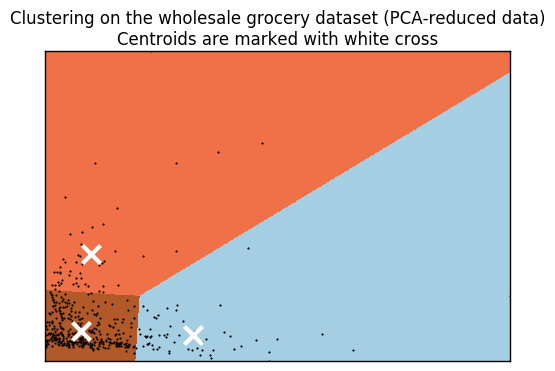

In [13]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

The first cluster contains customers that have vastly (around 3 times) higher spendings in the 'Fresh'-category compared to the average, indicating that those customers specialize in selling fresh products. Also, customers in this cluster tend to place many orders in the 'Frozen'- and 'Delicatessen'-Category, but relatively few in the 'Detergents and Paper'-category.

Customers in the second cluster tend to spend the most overall, with particularly high spendings in the categories 'Milk', 'Grocery' and 'Detergents and Paper' and relatively low spendings in the 'Fresh' and 'Frozen' categories. Overall, this indicates that customers in this segment sell products that are more durable (i.e. not fresh).

The last cluster reflects small customers that have below-average annual spendings for each of the items. Appart from the low total spending, it is apparent that the spending distribution across categories is not pathological, that is, there is no category for which spendings are particularly low or high (given that spendings are low overall).

Regarding the question targeted at distinguishing the clusters visually: I generally had no problems distinguishing the clusters. Besides that, one observation is that the PCA reduction does not result in clusters that are well separated from each other. Reducing the data to three or four dimensions only (instead of two) may result in clusters that have more separation, but adds the complexity of having to visually represent the data using an (hyper-)cube instead of a plane. Of course, one could try to improve cluster representation using a 3-component PCA and a cube.

*** CENTROIDS TRANSFERED TO ORIGINAL SPACE ***

[
 [ 35908.28;     6409.09;   6027.84;    6808.70;    1088.15;   2904.19]  (first cluster)
   
 [  7896.20;  18663.60;  27183.75;   2394.58;    12120.22;   2875.42]  (second cluster)
   
 [  8276.38;   3689.87;   5320.73;   2495.45;   1776.40;   1063.97]]  (third cluster)

<hr>
## Elbow Method

### Using the elbow method to find the optimal number of clusters 

One of the main challenges in unsupervised learning is that we do not know the definitive answer. We don't have the ground truth class labels in our dataset that allow us to apply the techniques in order to evaluate the performance of a supervised model. Thus, in order to quantify the quality of clustering, we need to use intrinsic metrics—such as the within-cluster SSE (distortion) to compare the performance of different k-means clusterings. Conveniently, we don't need to compute the within-cluster SSE explicitly as it is already accessible via the inertia_ attribute after fitting a KMeans model.

Based on the within-cluster SSE, we can use a graphical tool, the so-called elbow method, to estimate the optimal number of clusters k for a given task. Intuitively,
we can say that, if k increases, the distortion will decrease. This is because the
samples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly, which will become more clear if we plot distortion for different
values of k:

In [14]:
X = df[features]
y = df['Region']

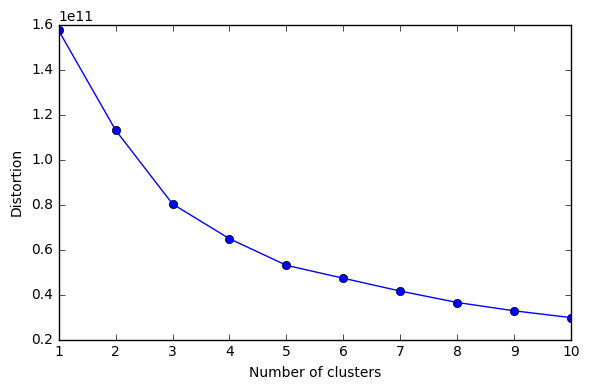

In [15]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions .append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

## Quantifying the quality of clustering via silhouette plots

Another intrinsic metric to evaluate the quality of a clustering is silhouette analysis, which can also be applied to clustering algorithms other than k-means that we will discuss later in this chapter. Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the samples in the clusters are. To calculate the silhouette coefficient of a single sample in our dataset, we can apply the following three steps:
1. Calculate the cluster cohesion a(i) as the average distance between a sample x(i) and all other points in the same cluster.
2. Calculate the cluster separation b(i) from the next closest cluster as the average distance between the sample x(i) and all samples in the nearest cluster.
3. Calculate the silhouette s(i) as the difference between cluster cohesion and separation divided by the greater of the two as shown : 

s(i) = b(i) - a(i) / max(b(i),a(i))

The silhouette coefficient is bounded in the range -1 to 1. Based on the preceding formula, we can see that the silhouette coefficient is 0 if the cluster separation and cohesion are equal (b(i)=a(i)). Furthermore, we get close to an ideal silhouette coefficient of 1 if (b(i)>>a(i)) since b(i) quantifies how dissimilar a sample is to other clusters, and a(i) tells us how similar it is to the other samples in its own cluster, respectively.
The silhouette coefficient is available as silhouette_samples from scikit-learn's metric module, and optionally the silhouette_scores can be imported. This calculates the average silhouette coefficient across all samples, which is equivalent to numpy.mean(silhouette_samples(…)). By executing the following code, we will now create a plot of the silhouette coefficients for a k-means clustering with k=3:


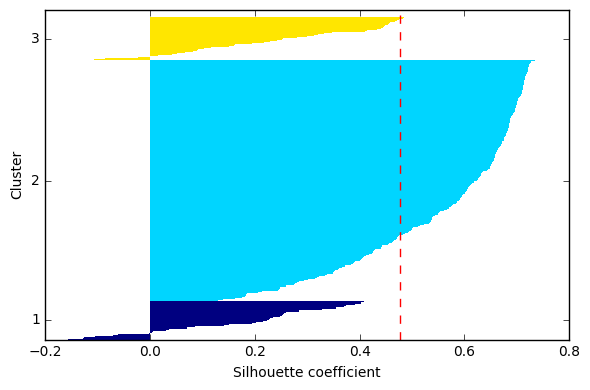

In [17]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

Thus our clustering with 3 centroids is good.

In [18]:
y.unique()

array([3, 1, 2], dtype=int64)

Also the regions are 3 which validates our assumption.

## Apply different unsupervised clustering techniques using Scikit-Learn

### Applying agglomerative clustering via scikit-learn

In [19]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
from sklearn.cross_validation import train_test_split
X = df[features]
y = df['Region']
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=42)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### K Means

In [22]:
from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=3, random_state=5)
clf.fit(X_train)
print (clf.labels_.shape)
print (clf.labels_)

(330,)
[1 1 2 2 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 1 1 1 2 1 1 1 1 0
 1 0 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 1 1 1 2 1 1 2 2 1 1 1 0 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 0 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 1 2
 1 2 1 1 1 1 2 0 2 2 1 1 2 1 1 0 1 1 1 2 1 1 2 0 1 1 1 2 2 1 1 1 1 1 1 2 1
 2 1 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 1 1 1 2 0 2 0 2 1 1 2 1 0 1 2 2
 1 1 1 1 2 1 2 1 2 1 1 2 1 1 2 1 1 1 2 1 1 0 1 1 1 0 0 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 2 2 1 0 1 2 1 1 1 1 1 2 0 1 2 1 1 1 0 1 1 2 2 1 2 1
 1 1 1 0 1 1 1 1 1 1 1 2 1 1 2 2 1 1 2 2 1 2 2 1 1 2 0 1 2 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 2 1]


In [23]:
# Predict clusters on testing data
y_pred = clf.predict(X_test)

In [24]:
from sklearn import metrics
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))
print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Addjusted rand score:-0.023
Homogeneity score:0.028 
Completeness score: 0.022 
Confusion matrix
[[ 0  0  0  0]
 [ 0  9  1  0]
 [ 1  5  2  0]
 [ 3 66 23  0]]


### Affinity Propogation

In [26]:
# Affinity propagation
aff = cluster.AffinityPropagation()
aff.fit(X_train)
print (aff.cluster_centers_indices_.shape)

(33,)


In [27]:
y_pred = aff.predict(X_test)

In [28]:
from sklearn import metrics
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))
print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Addjusted rand score:-0.001
Homogeneity score:0.26 
Completeness score: 0.052 
Confusion matrix
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  2  0  0  0  2  0  0  0  0  0  0  1  0  1  1  1]
 [ 1  0  0  0  1  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 3  0  3  0  4  9  5 10  1  1  2 13  4  4  9  1  2  4  5  3  2  2  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

### MeanShift

In [29]:
ms = cluster.MeanShift()
ms.fit(X_train)
print (ms.cluster_centers_)

[[  8.11076522e+03   3.49355217e+03   4.81676522e+03   2.34956087e+03
    1.67056522e+03   1.07935217e+03]
 [  1.82850000e+04   1.19360000e+04   3.25175000e+04   2.39500000e+02
    1.37160000e+04   3.14850000e+03]
 [  8.56500000e+03   4.98000000e+03   6.72980000e+04   1.31000000e+02
    3.81020000e+04   1.21500000e+03]
 [  3.27170000e+04   1.67840000e+04   1.36260000e+04   6.08690000e+04
    1.27200000e+03   5.60900000e+03]
 [  2.63730000e+04   3.64230000e+04   2.20190000e+04   5.15400000e+03
    4.33700000e+03   1.65230000e+04]
 [  2.29250000e+04   7.34980000e+04   3.21140000e+04   9.87000000e+02
    2.00700000e+04   9.03000000e+02]
 [  7.62370000e+04   3.47300000e+03   7.10200000e+03   1.65380000e+04
    7.78000000e+02   9.18000000e+02]
 [  1.82910000e+04   1.26600000e+03   2.10420000e+04   5.37300000e+03
    4.17300000e+03   1.44720000e+04]
 [  1.61170000e+04   4.61970000e+04   9.27800000e+04   1.02600000e+03
    4.08270000e+04   2.94400000e+03]
 [  3.59420000e+04   3.83690000e+04  

In [30]:
y_pred = ms.predict(X_test)

In [31]:
from sklearn import metrics
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))
print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Addjusted rand score:0.035
Homogeneity score:0.1 
Completeness score: 0.1 
Confusion matrix
[[ 0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0]
 [ 5  3  0  0  0  0  0]
 [80  3  0  0  4  4  1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


### Mixture of Guassian Models

In [34]:
from sklearn import mixture

# Define a heldout dataset to estimate covariance type
X_train_heldout, X_test_heldout, y_train_heldout, y_test_heldout = train_test_split(
        X_train, y_train,test_size=0.25, random_state=42)
for covariance_type in ['spherical','tied','diag','full']:
    gm=mixture.GMM(n_components=3, covariance_type=covariance_type, random_state=42, n_init=5)
    gm.fit(X_train_heldout)
    y_pred=gm.predict(X_test_heldout)
    print ("Adjusted rand score for covariance={}:{:.2}".format(covariance_type, 
                                                               metrics.adjusted_rand_score(y_test_heldout, y_pred)))


Adjusted rand score for covariance=spherical:-0.016
Adjusted rand score for covariance=tied:-0.08
Adjusted rand score for covariance=diag:0.029
Adjusted rand score for covariance=full:0.055


In [35]:
gm = mixture.GMM(n_components=3, covariance_type='tied', random_state=42)
gm.fit(X_train)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=42,
  tol=0.001, verbose=0)

In [37]:
# Print train clustering and confusion matrix
y_pred = gm.predict(X_test)
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))

print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Addjusted rand score:-0.044
Homogeneity score:0.015 
Completeness score: 0.025 
Confusion matrix
[[ 0  0  0  0]
 [ 0  9  1  0]
 [ 0  8  0  0]
 [ 1 83  8  0]]


### 

In [ ]:
pl=plt
from sklearn import decomposition
# In this case the seeding of the centers is deterministic,
# hence we run the kmeans algorithm only once with n_init=1

pca = decomposition.PCA(n_components=2).fit(X_train)
reduced_X_train = pca.transform(X_train)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will asign a color to each
x_min, x_max = reduced_X_train[:, 0].min() + 1, reduced_X_train[:, 0].max() - 1
y_min, y_max = reduced_X_train[:, 1].min() + 1, reduced_X_train[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

gm.fit(reduced_X_train)
#print np.c_[xx.ravel(),yy.ravel()]
Z = gm.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
pl.figure(1)
pl.clf()
pl.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=pl.cm.Paired,
          aspect='auto', origin='lower')
#print reduced_X_train.shape

pl.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = gm.means_

pl.scatter(centroids[:, 0], centroids[:, 1],
           marker='.', s=169, linewidths=3,
           color='w', zorder=10)

pl.title('Mixture of gaussian models on the seeds dataset (PCA-reduced data)\n'
         'Means are marked with white dots')
pl.xlim(x_min, x_max)
pl.ylim(y_min, y_max)
pl.xticks(())
pl.yticks(())
pl.show()

The plot of the data fitted by Guassian models looks like :
    
<img src="images/gmplot.png">

### Conclusions

PCA in combination with K-means-clustering was the most insightful solution technique. Even though only six features are present in the data, PCA identified the the two features with the highest variance and enabled me two cluster the data in a lower dimensional space. We used PCA over ICA for dimensionality reduction, since the PCA eigenvalues provide a convenient ordering of the most important variance directions (eigenvectors) of the data that can later be used in clustering. ICA does not provide a similar rank order for the most important components. After preprocessing the data with PCA, K-means uncovered (clustered) interpretable customer groups that are helpful to the client. We'hard-clustered' the data with K-means (instead of GMM) because there is no clear indication about the underlying data generating process and hence I prefered a method that does not assume Gausssian distributions. 
Due to the clustering, we can now tell the client that, among the large customers, one group focusses on the 'fresh' category and the other on more durable products. The small customers, however, have a more balanced assortment (and we also concluded that small customers actually exist.). 

## How would this help the company?

If the client plans to change, retire or introduce new (delivery) strategies in the future, she could use the segmentation k-means found to try the strategies on subsets of the segments. That is, the client could choose a small number of customers in each segment and introduce the change for those customers only. It could then, after some time, see how the customer segments respond to the change (for example by asking them for feedback). Based on this, the client may conclude to not proceed with the new strategy, proceed only for one or two customer segments, or implement it for the whole customer base. The ability to receive feedback on a new strategy from a small subset of customers before making a final decision is advantageous for the client.

## How would we use that data to help predict future customer needs?

If the client implemented a strategy for a subset of each of the customer segements and asked them to provide feedback on a, say, 1 (very poor) to 5 (great) scale, the client could then run a linear regression of the feedback provided on a set of cluster membership features (dummy variables) to identify the needs of each of the customer segments (note that this linear regression basically results in segment averages for the response). This will help the client to determine whether the new strategy suits the customers needs (by segment) or not.

___